# Importing the data
In order to import the data we will use the `fecon236` library, [here](https://github.com/MathSci/fecon236) there's its repo.


In [14]:
import fecon236 as fe # library with tools for financial economics
import pandas as pd
import numpy as np
import requests as req # Webscrapping
from bs4 import BeautifulSoup # Webscrapping
import re # Regex
import datetime
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from statsmodels.tsa.seasonal import seasonal_decompose #importing decomposition method
from statsmodels.tsa.stattools import adfuller

In [2]:
# We do webscrapping to get the stock symbols list of the IBEX 35 index, from Yahoo finance.
url = 'https://finance.yahoo.com/quote/%5EIBEX/components?p=%5EIBEX'

def get_symbols(url):
    html = req.get(url).content 
    soup = BeautifulSoup(html, "lxml")
    table = soup.find_all('a',{'class':'C($c-fuji-blue-1-b) Cur(p) Td(n) Fw(500)'})
    list = [link.attrs['title'] for link in table]
    return list

IBEX = get_symbols(url)


In [3]:
# We do a for loop to get the data of these stocks in the list and put them into a dataframe
df_ibex = pd.DataFrame(index=fe.get(f's4cabk.mc').index)

for stock in IBEX:
    a = pd.Series(data= fe.get(f's4{stock}')['Y'], name=stock[:-3])
    if len(a) == df_ibex.shape[0]: #we will take only stocks without nans
        df_ibex = df_ibex.join(a, how='left')


 ::  Retrieved from Yahoo Finance: CABK.MC
 ::  Retrieved from Yahoo Finance: ENG.MC
 ::  Retrieved from Yahoo Finance: ELE.MC
 ::  Retrieved from Yahoo Finance: AENA.MC
 ::  Retrieved from Yahoo Finance: FER.MC
 ::  Retrieved from Yahoo Finance: REE.MC
 ::  Retrieved from Yahoo Finance: GRF.MC
 ::  Retrieved from Yahoo Finance: NTGY.MC
 ::  Retrieved from Yahoo Finance: COL.MC
 ::  Retrieved from Yahoo Finance: SAB.MC
 ::  Retrieved from Yahoo Finance: CABK.MC
 ::  Retrieved from Yahoo Finance: MRL.MC
 ::  Retrieved from Yahoo Finance: IBE.MC
 ::  Retrieved from Yahoo Finance: IAG.MC
 ::  Retrieved from Yahoo Finance: SAN.MC
 ::  Retrieved from Yahoo Finance: MAP.MC
 ::  Retrieved from Yahoo Finance: VIS.MC
 ::  Retrieved from Yahoo Finance: AMS.MC
 ::  Retrieved from Yahoo Finance: BKT.MC
 ::  Retrieved from Yahoo Finance: ANA.MC
 ::  Retrieved from Yahoo Finance: BBVA.MC
 ::  Retrieved from Yahoo Finance: TL5.MC
 ::  Retrieved from Yahoo Finance: SGRE.MC
 ::  Retrieved from Yahoo Fi

# Exploring our dataset

In [4]:
# general overview
df_ibex.head()

,ENG,ELE,FER,REE,GRF,SAB,CABK,IBE,SAN,MAP,...,BBVA,TL5,SGRE,TEF,ACS,MEL,ITX,ACX,ENC,MTS
T,,,,,,,,,,,,,,,,,,,,,
2009-08-24,14.165,20.700001,6.05,8.1650,6.1300,3.09572,3.525,6.240,10.2726,2.86544,...,11.8748,7.31109,15.880,17.395700,36.650002,5.800,7.574,15.070,2.00893,53.337399
2009-08-25,14.100,20.820000,6.03,8.1700,6.1325,3.12881,3.540,6.285,10.4130,2.82276,...,12.2159,7.28847,15.975,17.544001,36.470001,5.690,7.526,15.005,2.00127,52.950600
2009-08-26,14.075,20.969999,6.03,8.1950,6.1400,3.13483,3.475,6.265,10.4082,2.87735,...,12.1150,7.22513,15.710,17.489599,36.349998,5.680,7.496,14.965,1.98980,51.342400
2009-08-27,14.010,20.775000,6.07,8.2900,6.1650,3.13483,3.450,6.350,10.4130,2.81978,...,12.0477,7.18442,15.530,17.440201,36.090000,5.665,7.374,14.800,1.99745,51.301601
2009-08-28,13.930,20.945000,6.23,8.1775,6.1250,3.18296,3.485,6.430,10.5002,2.84063,...,12.0717,7.21156,15.610,17.519300,36.139999,5.810,7.480,14.865,2.06633,52.339901


In [5]:
# checking dtypes ans null values
df_ibex.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2554 entries, 2009-08-24 to 2019-08-19
Data columns (total 22 columns):
ENG     2554 non-null float64
ELE     2554 non-null float64
FER     2554 non-null float64
REE     2554 non-null float64
GRF     2554 non-null float64
SAB     2554 non-null float64
CABK    2554 non-null float64
IBE     2554 non-null float64
SAN     2554 non-null float64
MAP     2554 non-null float64
VIS     2554 non-null float64
ANA     2554 non-null float64
BBVA    2554 non-null float64
TL5     2554 non-null float64
SGRE    2554 non-null float64
TEF     2554 non-null float64
ACS     2554 non-null float64
MEL     2554 non-null float64
ITX     2554 non-null float64
ACX     2554 non-null float64
ENC     2554 non-null float64
MTS     2554 non-null float64
dtypes: float64(22)
memory usage: 538.9 KB


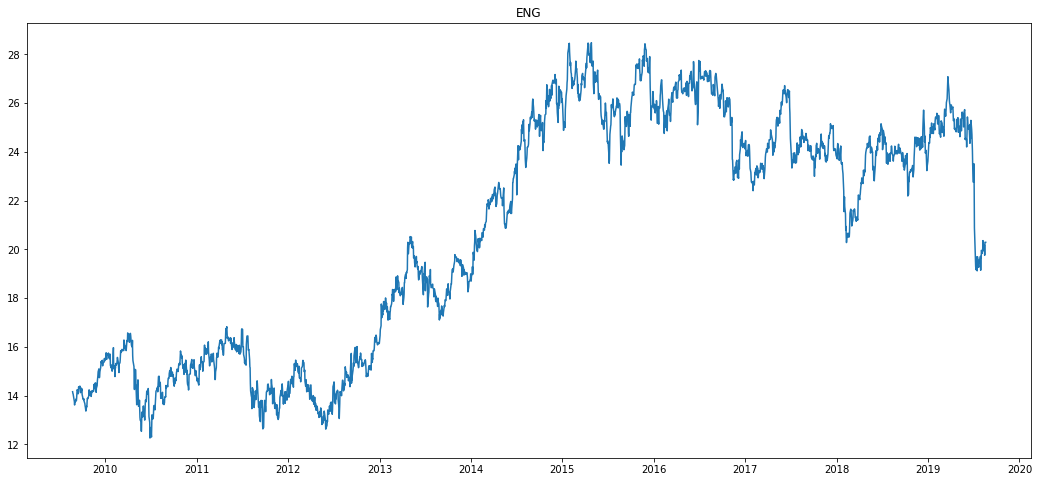

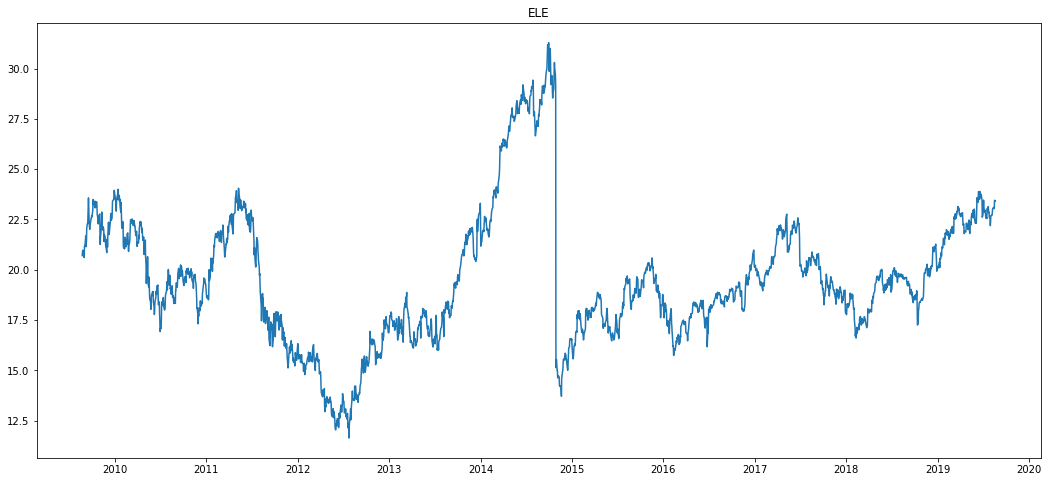

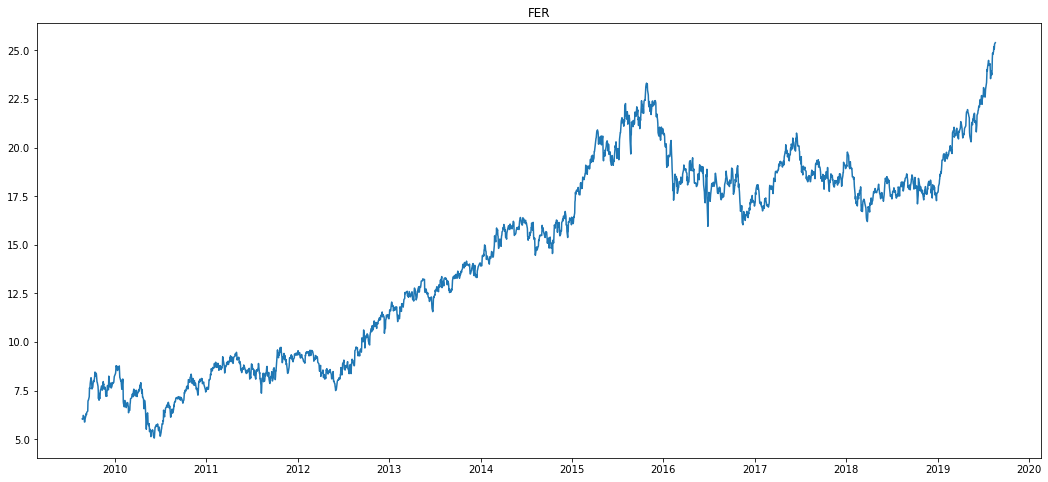

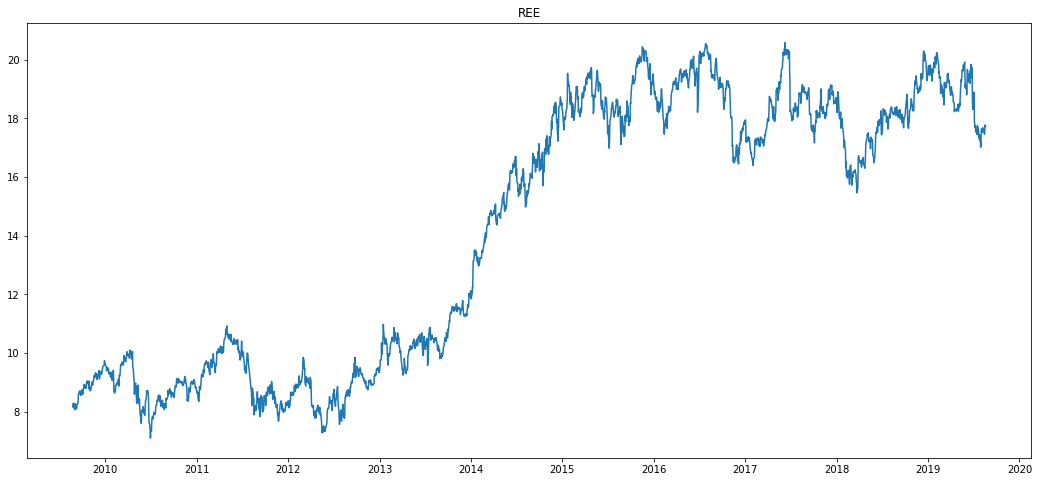

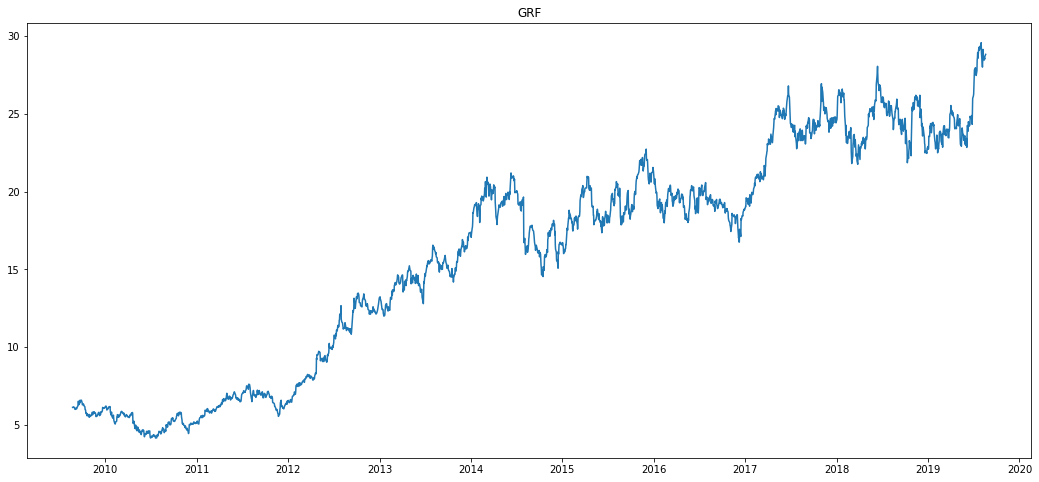

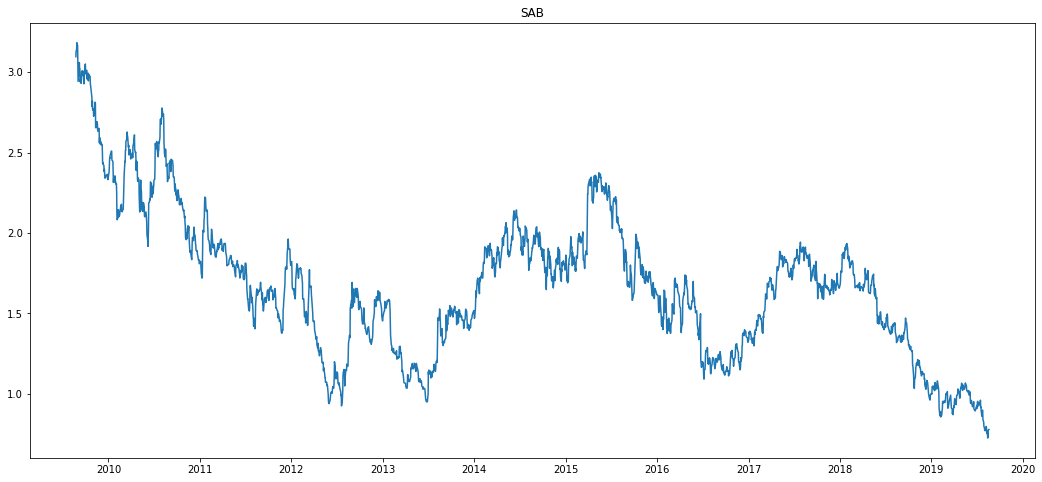

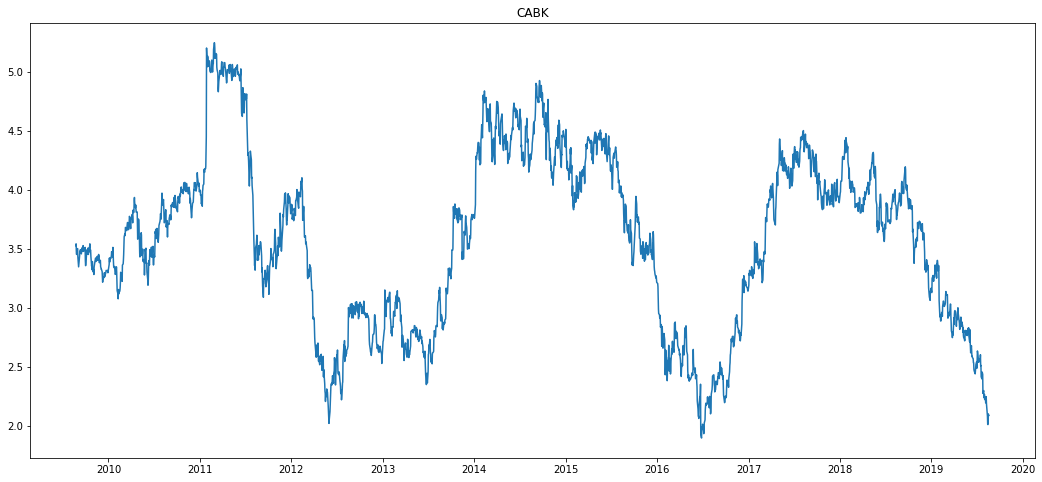

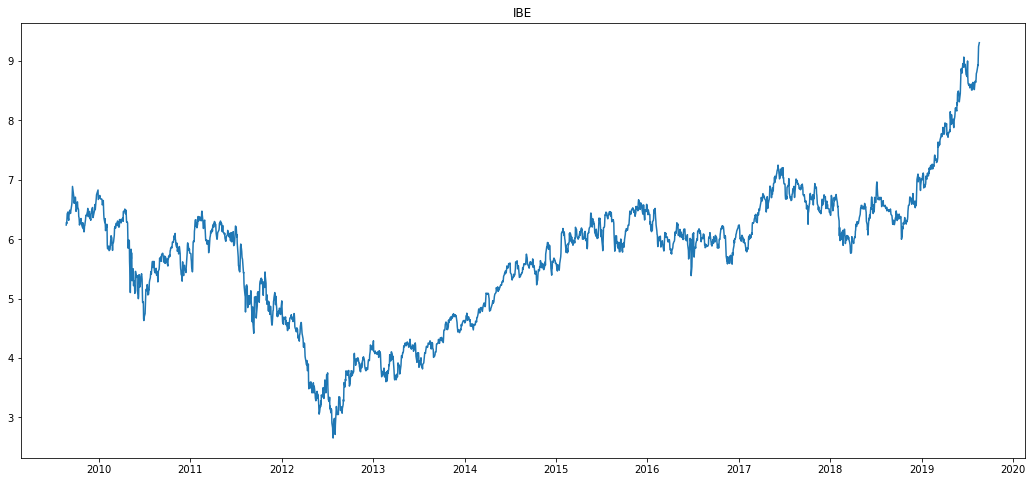

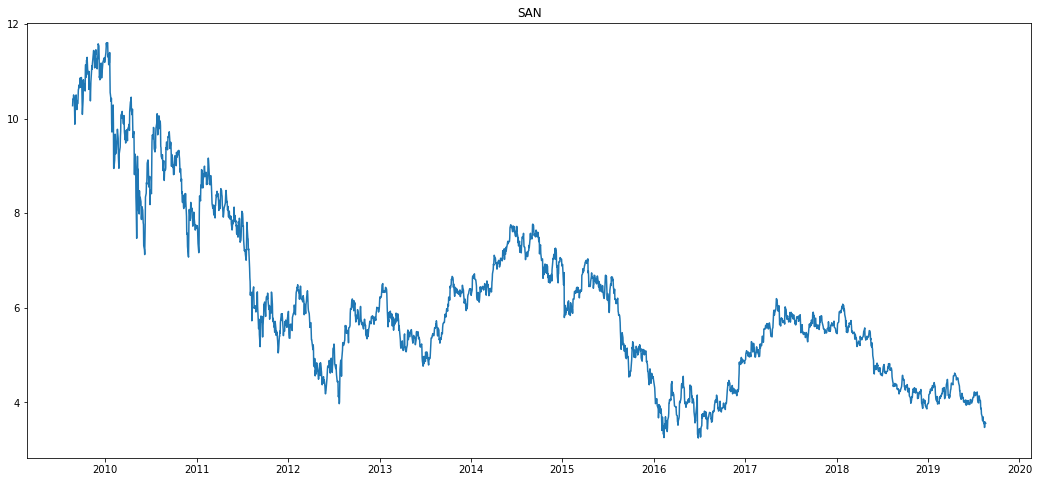

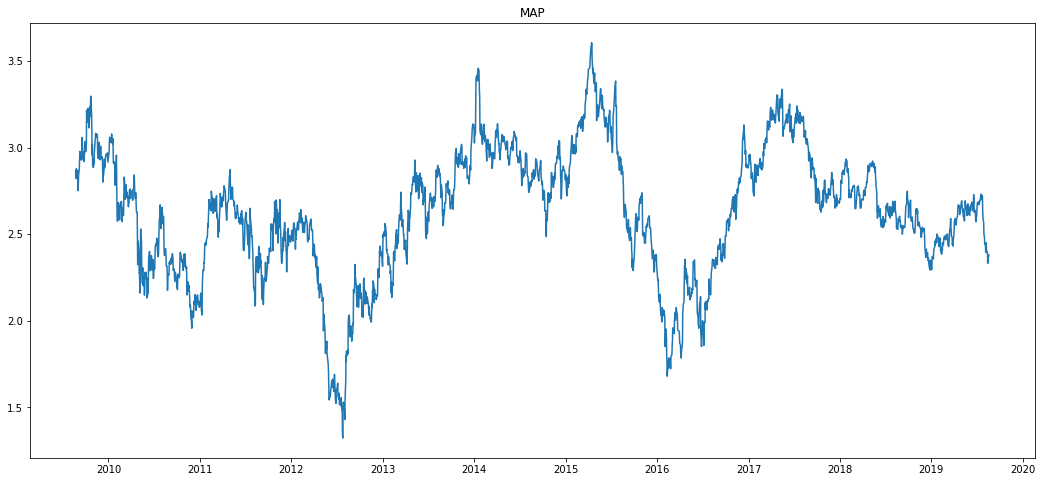

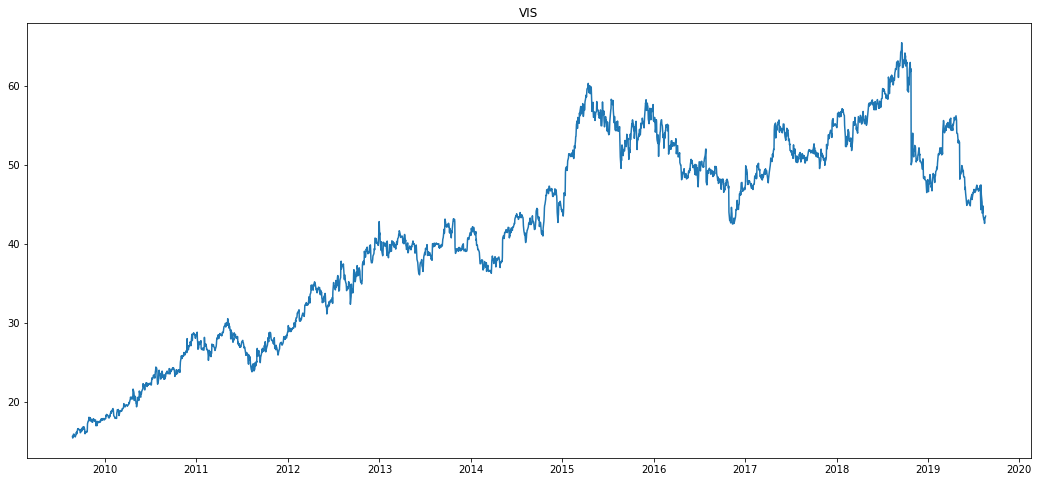

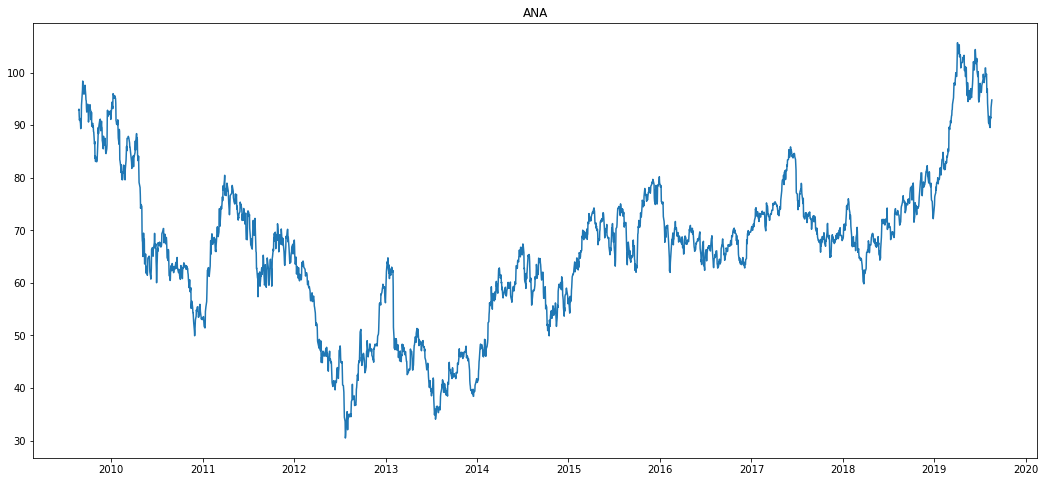

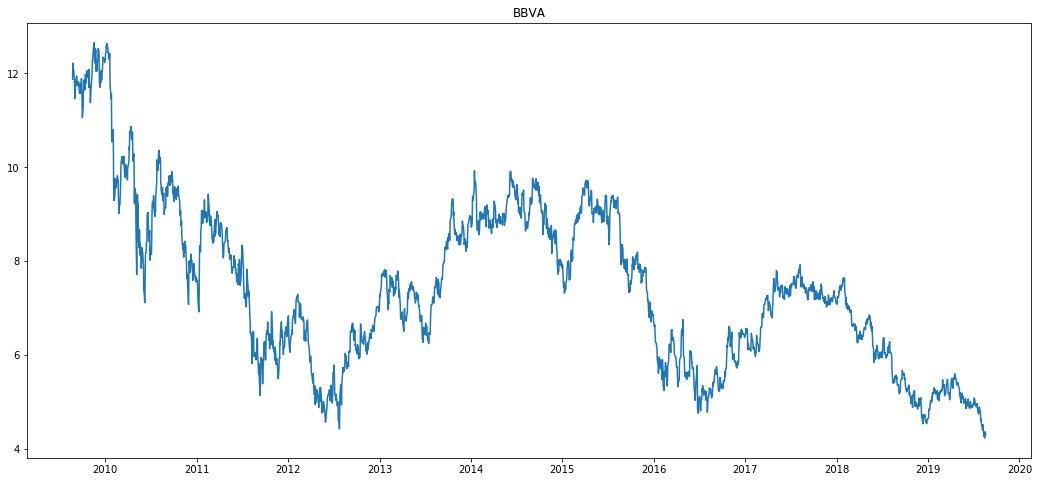

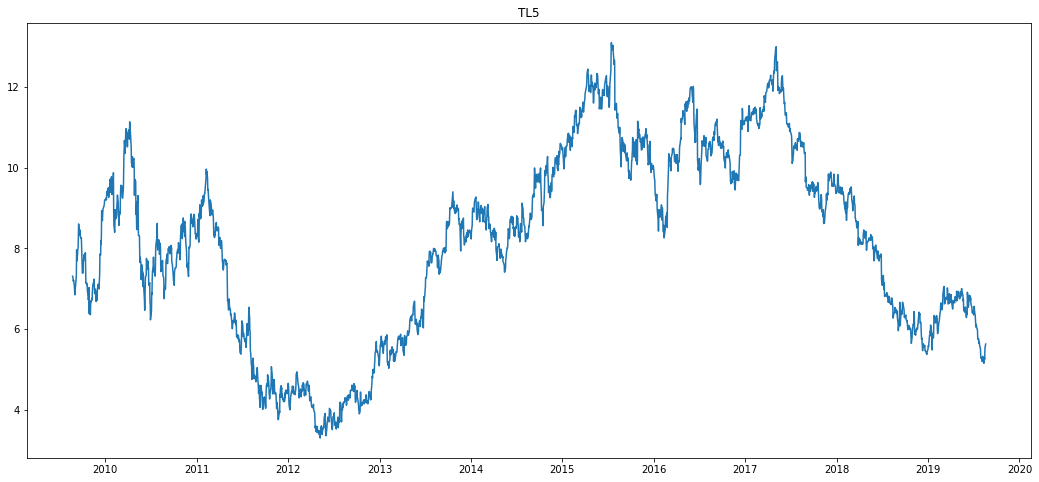

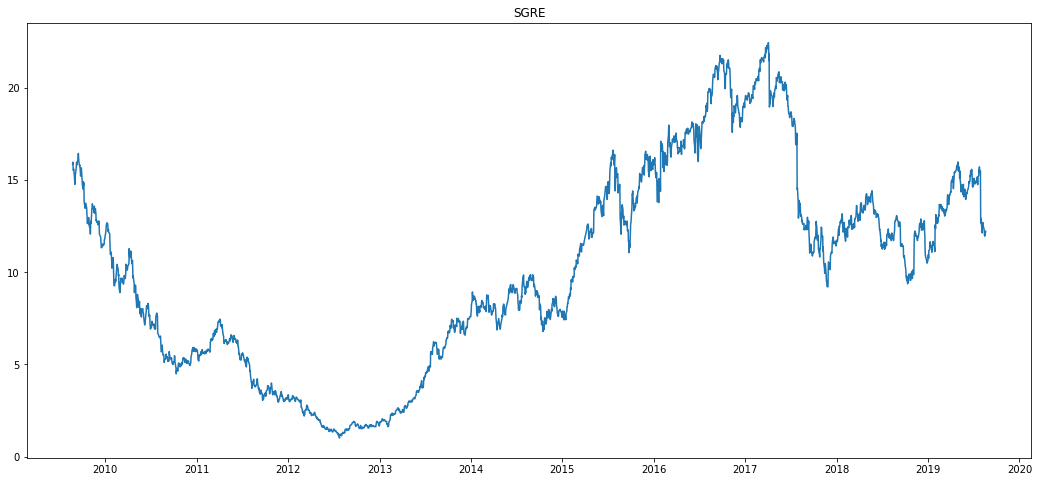

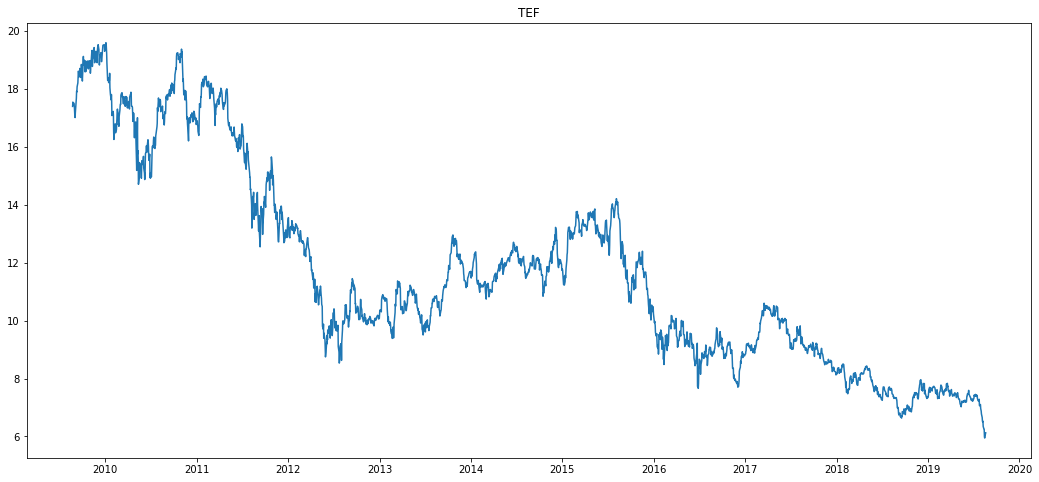

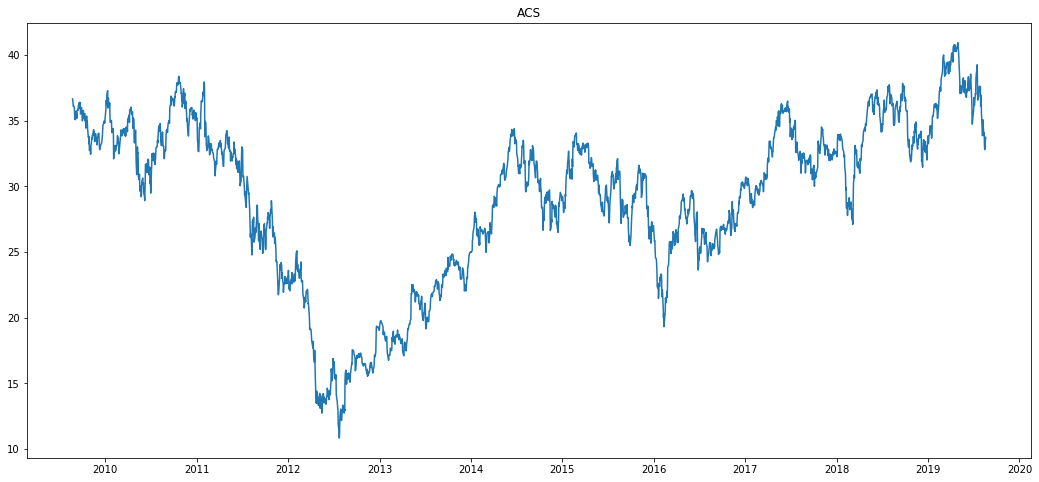

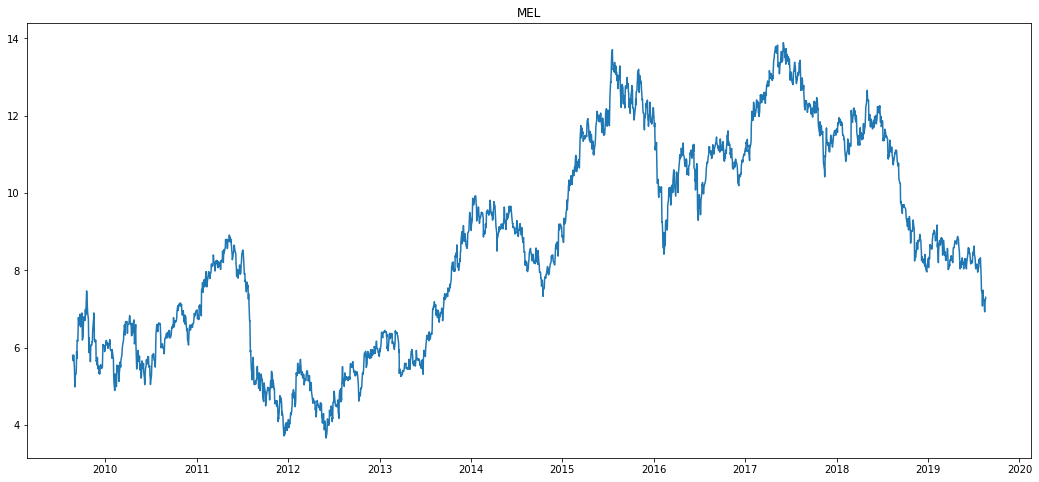

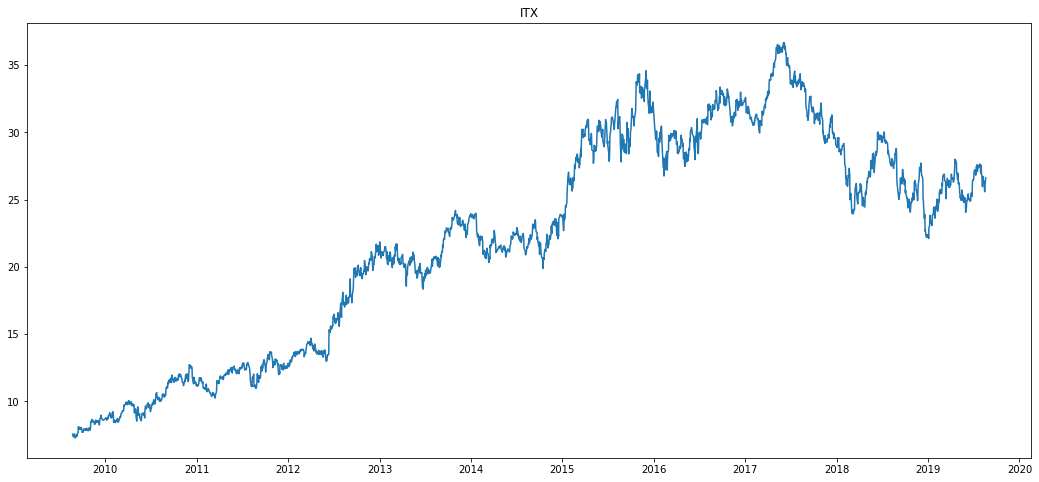

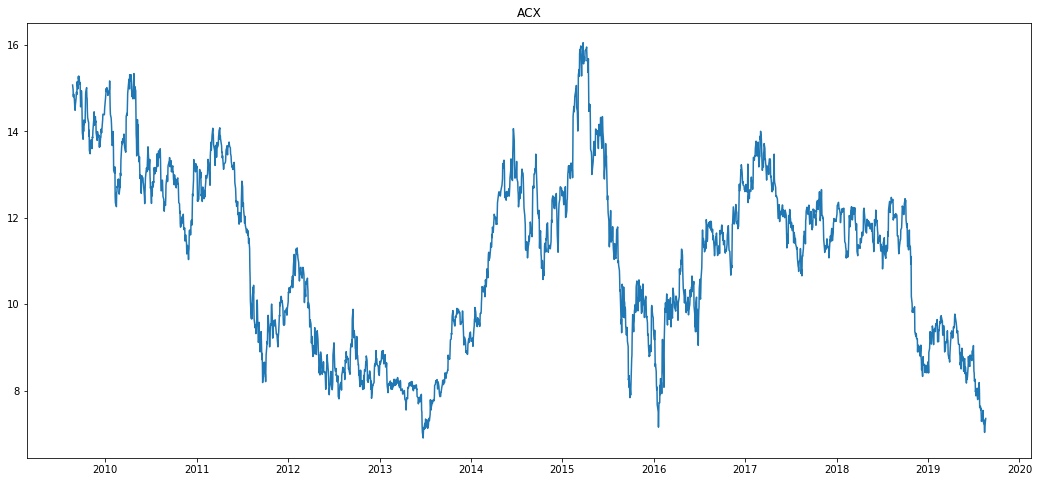

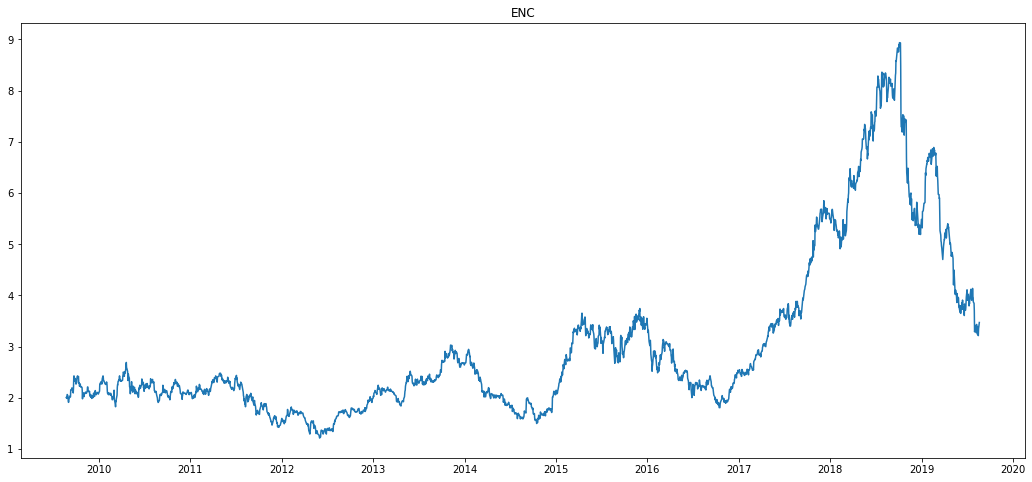

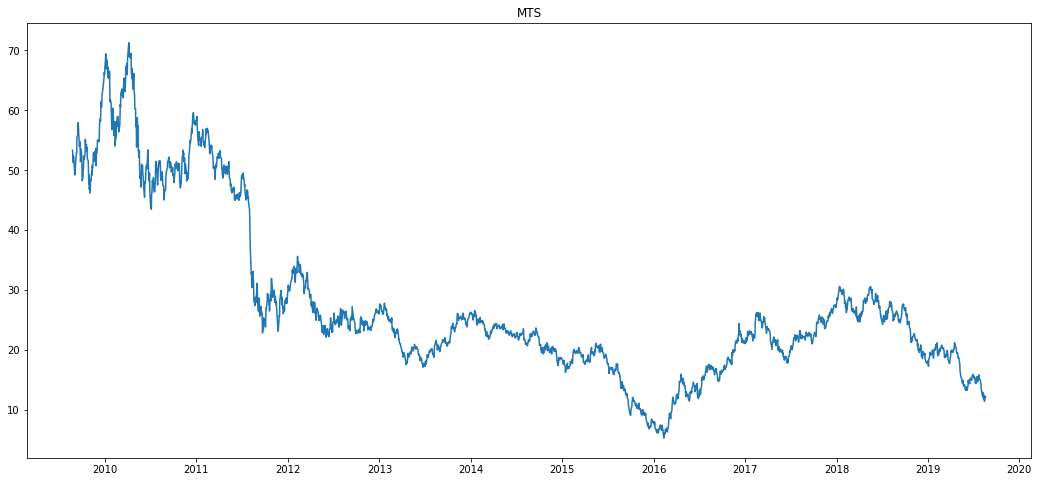

In [15]:
# we will plot the graphs
for stock in df_ibex.columns:
    plt.plot(df_ibex[stock])
    plt.title(stock, animated=True)
    plt.show()

# Decomposition and Dickey-Fuller test
With the decomposition we will eliminate seasonality and trend, after that with the test we will check which are the most stationary stocks.

In [7]:
#function that returns a test on stationarity

def test_stationarity(timeseries, column): 
    
    #Determing rolling statistics
    rolmean = timeseries[column].rolling(60).mean()
    rolstd = timeseries[column].rolling(60).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries[column], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best' )
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[column])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

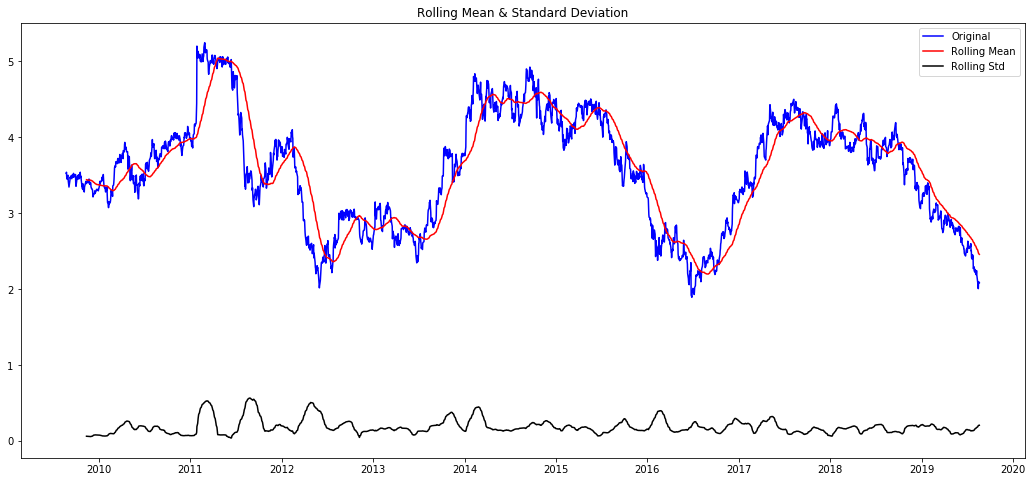

Results of Dickey-Fuller Test:
Test Statistic                   -1.895027
p-value                           0.334404
#Lags Used                        0.000000
Number of Observations Used    2553.000000
Critical Value (1%)              -3.432914
Critical Value (5%)              -2.862673
Critical Value (10%)             -2.567373
dtype: float64


In [16]:
# testing an example
test_stationarity(df_ibex, 'CABK')

#### We have no stationarity, the Test Statistic is over all the critical values.

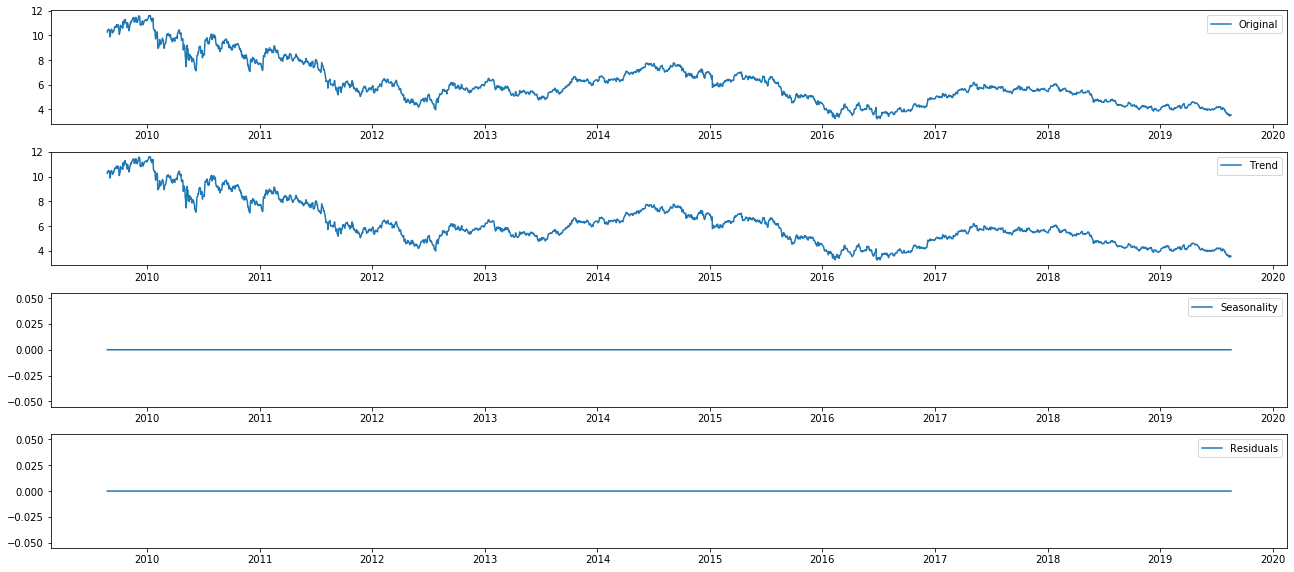

In [17]:
#WE'LL TRY TO DECOMPOSE THE EXAMPLE AND DOING THE TEST AGAIN AFTERWARDS

decomposition = seasonal_decompose(df_ibex['SAN'], freq=1) #decomposing with the method

#separing in variables all the results from decomposition.

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#plotting the results
plt.subplot(411)
plt.plot(df_ibex['SAN'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### The decomposition is not working as it may not identify any seasonality.

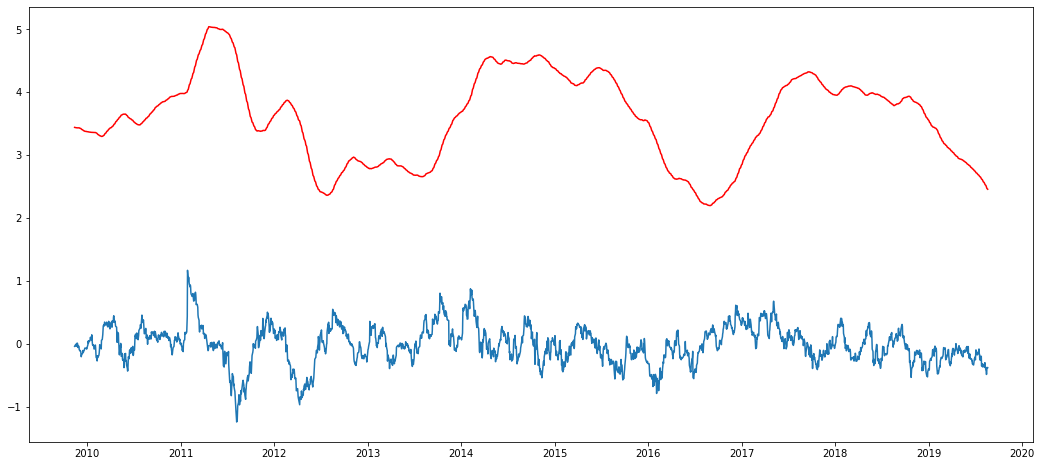

In [23]:
# WE'LL TRY TO ELIMINATE TREND WITH A SIMPLE MOVING AVERAGE
sma = df_ibex.rolling(60).mean()
sma_df = df_ibex - sma
sma_df.dropna(inplace=True)
sma.dropna(inplace=True)
plt.plot(sma_df['CABK'])
plt.plot(sma['CABK'], 'r')

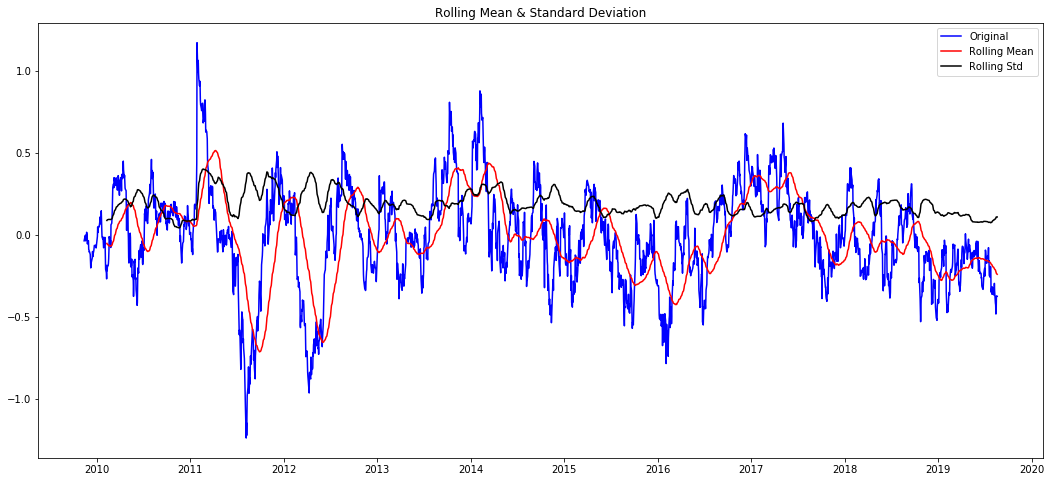

Results of Dickey-Fuller Test:
Test Statistic                -5.732960e+00
p-value                        6.535825e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.493000e+03
Critical Value (1%)           -3.432976e+00
Critical Value (5%)           -2.862700e+00
Critical Value (10%)          -2.567388e+00
dtype: float64


In [24]:
#we'll do the stationarity test now
test_stationarity(sma_df, 'CABK')

#### Now we have a stationary dataset

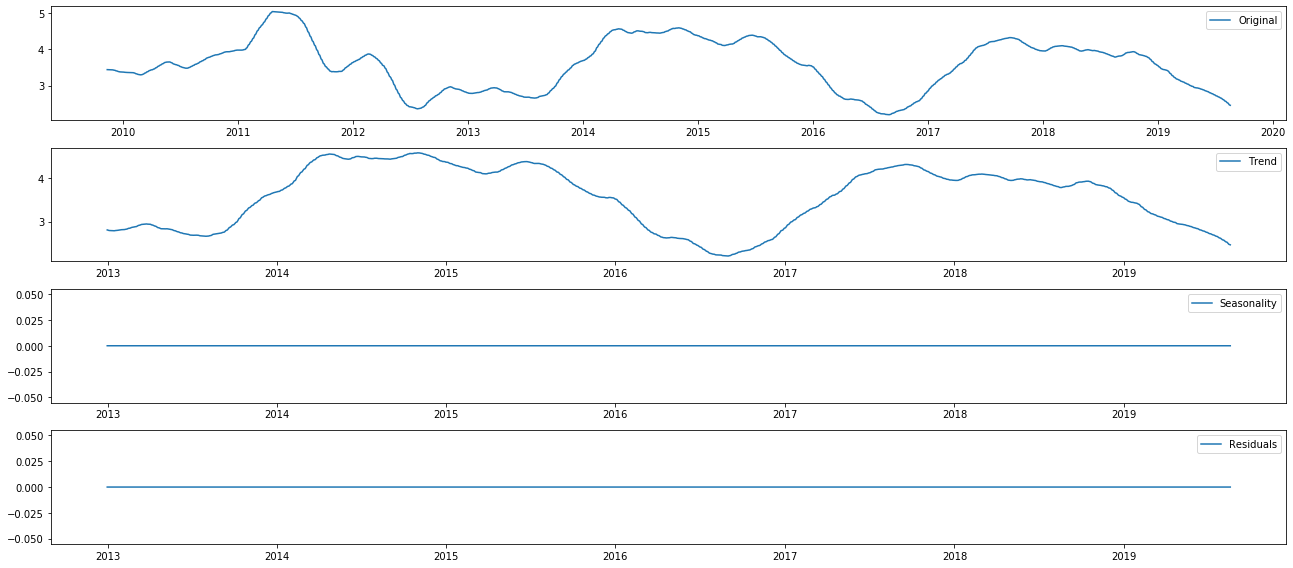

In [26]:
decomposition = seasonal_decompose(sma['CABK'][800:], freq=1) #decomposing with the method

#separing in variables all the results from decomposition.

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#plotting the results
plt.subplot(411)
plt.plot(sma['CABK'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()